# 0 Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# 1 Data

## 1.1 Parameters

In [107]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

epochs = 2**16            # number of learning epochs
design = [128, 64]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(2 * k/N)      # training-SNR
train_sigma = np.sqrt(1/(10**(train_SNR_Es/10)))    # training-sigma

## 1.2 Data Generation

In [108]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):    #一种不同于高斯近似的码字构造算法
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [109]:
# Create all possible information words
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

# Create sets of all possible codewords (codebook)
A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
x = np.zeros((2**k, N),dtype=bool)
u = np.zeros((2**k, N),dtype=bool)
u[:,A] = d

for i in range(0,2**k):
    x[i] = polar_transform_iter(u[i])

# 2 Model

In [110]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def fe(y_true, y_pred):
    tmp = tf.reduce_sum(tf.cast(tf.not_equal(y_true, tf.round(y_pred)), tf.int32), 1)
    return tf.reduce_sum(tf.cast(tf.cast(tmp, tf.bool), tf.int32))

def be(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.not_equal(y_true, tf.round(y_pred)), tf.int32))

In [111]:
# Define modulator
modulator_layers = [Lambda(modulateBPSK, 
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]

modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

In [112]:
# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]

noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

In [113]:
# Define decoder 
decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))

decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[fe, be])

In [114]:
# Define model
model_layers = modulator_layers + noise_layers + decoder_layers

model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss)

# 3 Training

In [115]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 520       
Total params: 10,952
Trainable params: 10,952
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = model.fit(x, d, batch_size=batch_size, epochs=epochs, verbose=0)

# 4 Testing

## NN Test

In [117]:
test_batch = 1000
num_words = 100000      # multiple of test_batch

ebn0_min = 0
ebn0_max = 5
points = 26
ebn0 = np.linspace(ebn0_min, ebn0_max, points)

bsum = np.zeros(points, dtype=np.float64)
be = np.zeros(points, dtype=np.float64)
fsum = np.zeros(points, dtype=np.float64)
fe = np.zeros(points, dtype=np.float64)

In [118]:
for i in range(0,points):
    SNR = ebn0[i] + 10*np.log10(2 * k/N)
    sigma = np.sqrt(1/(10**(SNR/10)))

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        x_test = np.zeros((test_batch, N),dtype=bool)
        u_test = np.zeros((test_batch, N),dtype=bool)
        u_test[:,A] = d_test

        for iii in range(0,test_batch):
            x_test[iii] = polar_transform_iter(u_test[iii])

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigma*np.random.standard_normal(s_test.shape)

        # Decoder
        tmp1, tmp2 = decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1:]
        fe[i] += tmp1
        be[i] += tmp2
        bsum[i] += test_batch*k
        fsum[i] += test_batch

In [119]:
ber = be/bsum
fer = fe/fsum

## Load MAP

In [120]:
result_map = np.loadtxt('map/polar/results_polar_map_{}_{}.txt'.format(N,k), delimiter=', ')
sigma_map = result_map[:,0]
bsum_map = result_map[:,1]
be_map = result_map[:,2]
fsum_map = result_map[:,3]
fe_map = result_map[:,4]

ebn0_map = 10*np.log10(1/(sigma_map**2)) - 10*np.log10(2 * k/N)
ber_map = be_map/bsum_map
fer_map = fe_map/fsum_map

## Plot Bit-Error-Rate

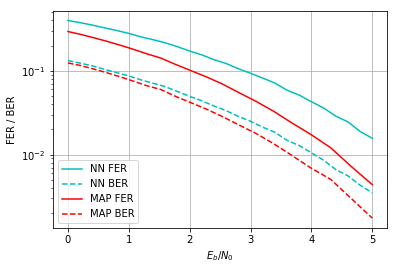

In [121]:
# [128, 64]
legend = ['NN FER', 'NN BER', 'MAP FER', 'MAP BER']

plt.plot(ebn0, fer, 'c') 
plt.plot(ebn0, ber, 'c--') 
plt.plot(ebn0_map, fer_map, 'r')
plt.plot(ebn0_map, ber_map, 'r--') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('FER / BER')    
plt.grid(True)
plt.show()

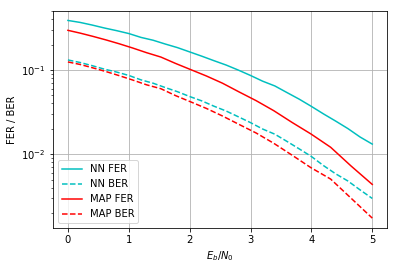

In [106]:
# [128, 128]
legend = ['NN FER', 'NN BER', 'MAP FER', 'MAP BER']

plt.plot(ebn0, fer, 'c') 
plt.plot(ebn0, ber, 'c--') 
plt.plot(ebn0_map, fer_map, 'r')
plt.plot(ebn0_map, ber_map, 'r--') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('FER / BER')    
plt.grid(True)
plt.show()

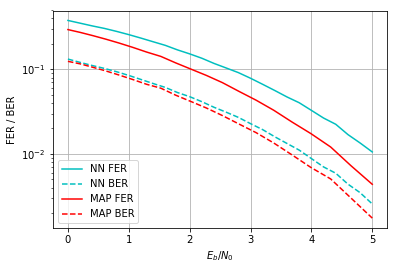

In [76]:
# [128, 64, 32]
legend = ['NN FER', 'NN BER', 'MAP FER', 'MAP BER']

plt.plot(ebn0, fer, 'c') 
plt.plot(ebn0, ber, 'c--') 
plt.plot(ebn0_map, fer_map, 'r')
plt.plot(ebn0_map, ber_map, 'r--') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('FER / BER')    
plt.grid(True)
plt.show()

# 5 Saving

In [91]:
L = pd.Series(history.history['loss'])
L.name = 'loss'

In [59]:
P_NN = pd.DataFrame([ebn0, fer, ber]).T
P_NN.columns = ['ebn0', 'fer', 'ber']
P_MAP = pd.DataFrame([ebn0_map, fer_map, ber_map]).T
P_MAP.columns = ['ebn0_map', 'fer_map', 'ber_map']

In [58]:
model.save('./result/model_16_8.h5')

In [96]:
L.to_csv('./result/LOSS_16_8.csv', header = True, index = False)

In [67]:
P_NN.to_csv('./result/P_NN_16_8.csv', header = True, index = False)
P_MAP.to_csv('./result/P_MAP_16_8.csv', header = True, index = False)